In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from empiricaldist import Pmf
from scipy.stats import binom

def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Estimating Counts:


### The Train problem

```
“A railroad numbers its locomotives in order 1..N. One day you see a locomotive with the number 60. Estimate how many locomotives the railroad has.”
```

What we know?
- We know the railroad has 60 or more locomotives (assuming of course that they always mark in incremental order)

Bayesian Reasoning:

- What did we know about `N` prior to seeing data? **Prior**
- For any given value of `N` what is the likelihood of seeing the data (a locomotive with number 60)? **Likelihood**

In [3]:
# we can just assume 1-1000 are equally likely
hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

#### Likelihood

- In a hypothetical fleet of `N` locomotives, what is the probability we would see 60?
- If we assume equally likely to see any locomotive then $\frac{1}{N}$ is the chance

In [4]:
def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos) # if we see a number > hypo
    likelihood[impossible] = 0 # then it becomes 0
    pmf *= likelihood
    pmf.normalize()

Max: 60


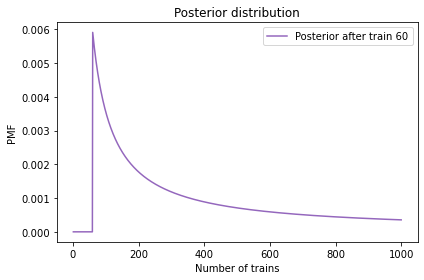

In [5]:
# we see a 60
data = 60
posterior = prior.copy()
update_train(posterior, data)

# plot it out
posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution');

print(f"Max: {posterior.max_prob()}")

#### Points to Make:

- Any `N` hypothesis < 60 is ruled out to 0
- most likely value is the data we saw
    - this should make us uncomfortable - unlikely that we just happened to see the train with the highest number in our viewing.   
- we could compute the mean of the posterior distribution, which is the expected value
    - $\sum_{i} p_{i}q_{i}$

In [6]:
print(np.sum(posterior.ps * posterior.qs))
print(posterior.mean())

333.41989326370776
333.41989326370776


### Sensitivity to Prior:

If we vary our upper bound we start to see large shifts in the mean given we only have one observation

We can resolve this by:
- getting more data
- choosing a better prior with background information 

In [7]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


In [8]:
# let's add two more observations: 
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


### Power Law Prior:

Most fields have many small, a few medium, and 1-2 very large companies. 

Equation:
- `N`: number of companies with a given size


$ N \propto \frac{1}{N}^{\alpha}$

In [9]:
# building a power law:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

# and add uniform:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

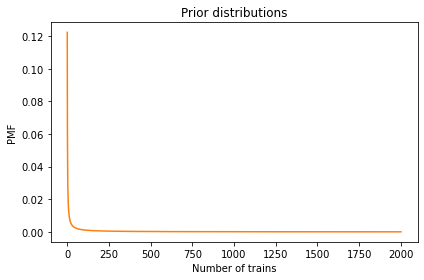

In [10]:
# puts much more initial weight on lower number of trains
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

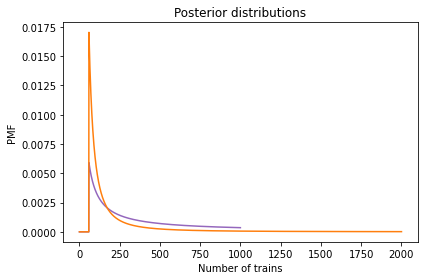

In [11]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

# plot:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

In [12]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


#### Takeaways:

- The upper bound becomes less relevant with the power law - our posterior shows lower likelihood for higher values even given the data. 

- Our expected values are all very close, driven by data viewed and reduced impact of higher values

### Credible Intervals vs Confidence Intervals:

Point estimates are not very helpful, which is why we turn to other approaches. 

Refresher: https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval

*confidence intervals*
- a range of values that should include the true value of the parameter with some minimum probability (e.g. 95%)
- Out of every 100 experiments, at least 95 of the resulting confidence intervals will be expected to include the true value of the parameter. 
- frequentist believes the parameter has one (unknown) balue


*credible intervals*
- bayesian assume parameter's value is fixed but has been chosen from some prob distribution, which means we can capture uncertainty by using a prior distribution
- this can be interpreted as a probabilistic statement about the parameter 


#### percentile rank: 
- find all values less than or equal to some `x`, sum up the corresponding probabilities


In [13]:
# compute probability that company has <= 100 trains
power.prob_le(100)

0.2937469222495771

In [15]:
# alternatively, we can find the median by summing up probabilities for values until we equal or exceed:
def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items(): # unpack quantity and probability
        total += p # sum of probs
        if total >= prob:  # once we exceed prob of interest we return the quantity
            return q
    return np.nan

# find median of posterior
quantile(power, 0.5)

113

In [16]:
# or we can just use Pmg
power.quantile([0.5])

array([113.])

In [17]:
# 90% credible interval
power.quantile([0.05, 0.95])

array([ 91., 243.])

In [18]:
# or,
power.credible_interval(0.9)

array([ 91., 243.])

### German Tank Problem:

